## For purpose of tutorial this notebook was taken from [ launching.ipynb](https://gitlab.com/meso/paper-magnetic-qsh/blob/9b72be56140568be3277f0a115ef331e23168bb6/examples)

# Local engines

In [1]:
import ipyparallel
rc = ipyparallel.Client(profile='dev2')

# Cluster engines

In [2]:
# import sys
# sys.path.append('/home/rskolasinski/paper-magnetic-qsh/scripts/')

# from hpc05 import HPC05Client
# rc = HPC05Client()

# Other imports

In [3]:
path = '/home/rskolasinski/paper-magnetic-qsh/code'
import sys; sys.path.append(path)
import bhz
import git_version

import numpy as np
import pandas as pd
from itertools import product

In [4]:
import holoviews as hv
%reload_ext holoviews.ipython

In [5]:
lview = rc.load_balanced_view()

In [6]:
len(rc)

20

# Parallel note

Location of ``bhz.py`` is added to ``sys.path`` on engines with startup script. Module is also imported by startup script.

Startup script is defined by 
```
c = get_config()
c.IPEngineApp.startup_script = u'/path/to/my/startup.py'
```
inside ``.ipython/profile_<profile_name>/ipengine_config.py``

Please see ipyparalell [documentation](https://ipyparallel.readthedocs.org/en/latest/process.html?highlight=startup#configuring-ipengine) for details.

# Parameters

In [7]:
# This columns order is valid when output contains *ONLY* this fields.
# This is situation for now when bhz.calculate_conductance returns
# dict which keys are same as simulation_parameters fields plus 'G'.
columns = bhz.nt_sim._fields + ('G', 'machine', 'branch_status', 'commit')

# Calculating conductance

In [8]:
def calculate(inp):
    ''' Calculate whatever needs to be calculated.
    
    This function use ``bhz`` and ``git_version`` from global namespace
    of interpreter it is launch from. Localy it is namespace of this notebook,
    on remote engines it is namespace of engines.
    '''
    output = bhz.calculate_conductance(inp)
    output.update(git_version.check_git_commit(bhz.__file__))
    return output

## Executing one simulation

In [9]:
mus = np.linspace(-.02, .02, 60)
inps = [bhz.define_parameters(L=60, W=60, mu=mu, mu_lead=0.2)  for mu in mus]

In [10]:
async = lview.map_async(calculate, inps)
async.wait_interactive()

  60/60 tasks finished after    8 s
done


### Looking into output

In [11]:
data = async.get()
df = pd.DataFrame(data, columns=columns)
df[:2]

L   W  V  a  Bx  By  dis salt  mu_lead        mu         G     machine  \
0  60  60  0  4   0   0    0           0.2 -0.020000  4.106173  qclab-hpc1   
1  60  60  0  4   0   0    0           0.2 -0.019322  4.736789  qclab-hpc1   

      branch_status                                    commit  
0  develop_modified  ffc93e4f6fb5d0442aa0d67f5fdfb6cd6048be75  
1  develop_modified  ffc93e4f6fb5d0442aa0d67f5fdfb6cd6048be75

### Let skip unique or not important info

In [12]:
df = df.drop('machine', axis=1)
df = df.loc[:, df.apply(pd.Series.nunique) != 1]
df[:2]

mu         G
0 -0.020000  4.106173
1 -0.019322  4.736789

### And plot it

:Curve   [mu]   (G)
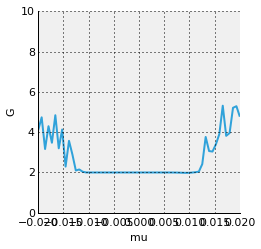

In [13]:
example = hv.DFrame(df)
hmap = example.curve('mu', 'G', extents=(None, 0, None, 10))
hmap

## Executing few simulations

In [14]:
inps = {
    'L'       : [60],
    'W'       : [60],
    'a'       : [4],

    'mu'      : np.linspace(-.02, .02, 50),
    'mu_lead' : [0.2],

    'Bx'      : [0, 4, 8],
}     


inps = [{k: v for k, v in zip(inps.keys(), x)} for x in list(product(*inps.values()))]
inps = [bhz.define_parameters(**kwargs) for kwargs in inps] 
inps = sorted(inps)

In [15]:
async = lview.map_async(calculate, inps)
async.wait_interactive()
data = async.get()

df = pd.DataFrame(data, columns=columns)
df = df.drop('machine', axis=1)
df = df.loc[:, df.apply(pd.Series.nunique) != 1]

 150/150 tasks finished after   18 s
done


:HoloMap   [Bx]
   :Curve   [mu]   (G)
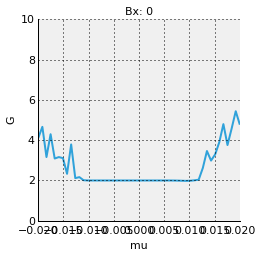
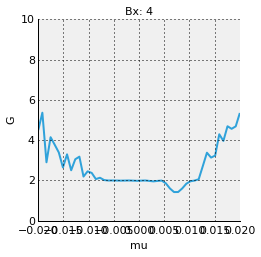
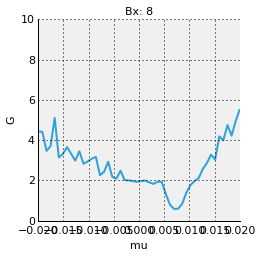

In [16]:
def allbut(columns, *names):
    allnames = list(columns)
    names = set(names)
    return [item for item in allnames if item not in names]

example = hv.DFrame(df)
hmap = example.curve('mu', 'G', mdims=allbut(df.columns, 'mu', 'G'), 
                     extents=(None, 0, None, 10))

hmap